In [1]:
# %reload_ext autoreload
# %autoreload 2
from typing import Optional, Tuple, Literal
import os
import sys
import time
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy
import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
import jax.random as jrandom 
import jax.nn as jnn
import equinox as eqx
import optax
from tqdm.notebook import tqdm
from collections import defaultdict
from functools import partial
from scipy.stats import spearmanr, pearsonr

jax.config.update('jax_enable_x64', True)
jax.config.update('jax_platforms', 'cpu')

# jax.config.update('jax_check_tracer_leaks', True) 
sys.path.append("../../..")
# %reload_ext autoreload
# %autoreload 2
    
from lib.base import Config, Module
from lib.ml.in_models import InICENODELiteICNNImpute
from lib.ml.rectilinear_modules import ZeroImputer, MeanImputer, RectilinearImputer
from lib.ml.experiment import Experiment
from lib.metric.metrics import MetricsCollection
import lib.ehr.example_datasets.mimiciv_aki as m4aki
from lib.ehr.tvx_transformations import TrainingSplitGroups
from lib.ehr.tvx_ehr import TVxEHR
from lib.utils import modified_environ, write_config, append_params_to_zip, zip_members, load_config, translate_path
from lib.ml.icnn_modules import  ProbICNNImputerTrainer

import pub_ready_plots
from pub_ready_plots import get_mpl_rcParams
rc_params, fig_width_in, fig_height_in = pub_ready_plots.get_mpl_rcParams(
    width_frac=1,  # between 0 and 1
    height_frac=0.2,  # between 0 and 1
    layout="jmlr"  # or "iclr", "neurips", "poster-portrait", "poster-landscape"
)
rc_params['figure.constrained_layout.use'] = True

# rc_params['font.size'] = 10
# rc_params['axes.titlesize'] = 12
# rc_params['axes.labelsize'] = 10
# rc_params['legend.fontsize'] = 10

plt.rcParams.update(rc_params)
# %reload_ext autoreload
# %autoreload 2

In [2]:
# EVAL_CONFIG_FILE = '/home/asem/GP/ICENODE/experiment_templates/icu/eval_config.json'
# metrics_config = Config.from_dict(load_config(translate_path(EVAL_CONFIG_FILE))).metrics
# metrics = MetricsCollection(metrics=tuple(Module.import_module(config=config) for config in metrics_config))

EXP_DIR = f'{os.environ["HOME"]}/GP/ehr-data/aki_out/seg_auto/AutoODEICNN_mlpdyn_g0_novograd'
experiment = Experiment(Config.from_dict(load_config(os.path.join(EXP_DIR, 'config.json'))))

In [3]:
def gen_data(tvx):
    
    obs = [adm.observables  for subject in tvx.subjects.values() for adm in subject.admissions]
    adm_id = sum(([adm.admission_id] * len(adm.observables.time)  for subject in tvx.subjects.values() for adm in subject.admissions), [])
    subj_id = sum(([subject.subject_id] * len(adm.observables.time)  for subject in tvx.subjects.values() for adm in subject.admissions), [])
    
    obs_val = np.vstack([obs_i.value for obs_i in obs])
    obs_mask = np.vstack([obs_i.mask for obs_i in obs])
    obs_time = np.hstack([obs_i.time for obs_i in obs])
    obs_time_index = np.hstack([np.arange(len(obs_i.time)) for obs_i in obs])
    
    tvx.scheme.obs
    features = list(map(tvx.scheme.obs.desc.get, tvx.scheme.obs.codes))
    
    
    obs_val = pd.DataFrame(obs_val, columns=features)
    obs_mask = pd.DataFrame(obs_mask.astype(int), columns=features)
    meta = pd.DataFrame({'subject_id': subj_id, 'admission_id': adm_id, 'time': obs_time, 'time_index': obs_time_index})

    artificial_mask = obs_mask.copy()
    artificial_mask = obs_mask & np.array(jrandom.bernoulli(jrandom.PRNGKey(0), p=0.8, shape=obs_mask.shape))
    return obs_val, obs_mask, artificial_mask, meta

def art_mask_tvx(tvx, art_mask, meta):
    admission_art_mask = defaultdict(dict)
    for (subject_id, admission_id), meta_adm_df in meta.groupby(['subject_id', 'admission_id']):
        admission_art_mask[str(subject_id)][str(admission_id)] = art_mask.loc[meta_adm_df.index].to_numpy()
    masked_subjects = {}
    for subject_id, art_masks in admission_art_mask.items():
        masked_subject = tvx.subjects[subject_id]
        admissions = {admission.admission_id: admission for admission in masked_subject.admissions}
        masked_admissions = {a.admission_id: a for a in masked_subject.admissions if a.admission_id not in art_mask}
        for admission_id, art_mask in art_masks.items():
            obs = admissions[admission_id].observables
            obs = eqx.tree_at(lambda x: x.value, obs, np.where(art_mask, obs.value, 0.0))
            obs = eqx.tree_at(lambda x: x.mask, obs, art_mask)
            masked_admissions[admission_id] = eqx.tree_at(lambda x: x.observables, admissions[admission_id], obs)
        masked_admissions = list(map(masked_admissions.get, (a.admission_id for a in masked_subject.admissions)))
        masked_subjects[subject_id] = eqx.tree_at(lambda x: x.admissions, masked_subject, masked_admissions)
    return eqx.tree_at(lambda x: x.subjects, tvx, masked_subjects)

In [4]:
# tvx0 = TVxEHR.load("/home/asem/GP/ehr-data/mimic4aki-cohort/tvx_aki_0.h5")
# tvx1 = TVxEHR.load("/home/asem/GP/ehr-data/mimic4aki-cohort/tvx_aki_1.h5")

# obs_val0, obs_mask0, art_mask0, meta0 = gen_data(tvx0)
# obs_val1, obs_mask1, art_mask1, meta1 = gen_data(tvx1)

# obs_val0.to_csv('g0g1_missingness_data/missingness_vals0.csv')
# obs_mask0.to_csv('g0g1_missingness_data/missingness_mask0.csv')
# art_mask0.to_csv('g0g1_missingness_data/missingness_artificial_mask0.csv')
# meta0.to_csv('g0g1_missingness_data/missingness_meta0.csv')

# obs_val1.to_csv('g0g1_missingness_data/missingness_vals1.csv')
# obs_mask1.to_csv('g0g1_missingness_data/missingness_mask1.csv')
# art_mask1.to_csv('g0g1_missingness_data/missingness_artificial_mask1.csv')
# meta1.to_csv('g0g1_missingness_data/missingness_meta1.csv')



In [5]:
obs_val0 = pd.read_csv('g0g1_missingness_data/missingness_vals0.csv', index_col=[0])
obs_mask0 = pd.read_csv('g0g1_missingness_data/missingness_mask0.csv', index_col=[0])
art_mask0 = pd.read_csv('g0g1_missingness_data/missingness_artificial_mask0.csv', index_col=[0])
meta0 = pd.read_csv('g0g1_missingness_data/missingness_meta0.csv', index_col=[0])

obs_val1 = pd.read_csv('g0g1_missingness_data/missingness_vals1.csv', index_col=[0])
obs_mask1 = pd.read_csv('g0g1_missingness_data/missingness_mask1.csv', index_col=[0])
art_mask1 = pd.read_csv('g0g1_missingness_data/missingness_artificial_mask1.csv', index_col=[0])
meta1 = pd.read_csv('g0g1_missingness_data/missingness_meta1.csv', index_col=[0])

In [6]:
# masked_tvx1 = art_mask_tvx(tvx1, art_mask1, meta1)
# tvx1_subjects = list(masked_tvx1.subjects.keys())
# test_size = 1000
# seed = 0
# indices = jrandom.permutation(jrandom.PRNGKey(seed), len(tvx1_subjects))
# test_idx = tuple(tvx1_subjects[i] for i in indices[:test_size].tolist())
# masked_tvx1_sample = TrainingSplitGroups.subset(masked_tvx1, test_idx)   
# masked_tvx1_sample.save("g0g1_missingness_data/masked_tvx1_sample.h5")
# sampled_masked_obs_val1, sampled_masked_obs_mask1, _, sampled_masked_meta1 = gen_data(masked_tvx1_sample)
# sampled_masked_obs_val1.to_csv('g0g1_missingness_data/missingness_sampled_masked_val1.csv')
# sampled_masked_obs_mask1.to_csv('g0g1_missingness_data/missingness_sampled_masked_mask1.csv')
# sampled_masked_meta1.to_csv('g0g1_missingness_data/missingness_sampled_masked_meta1.csv')


masked_tvx1_sample = TVxEHR.load("g0g1_missingness_data/masked_tvx1_sample.h5")
sampled_masked_obs_val1 = pd.read_csv('g0g1_missingness_data/missingness_sampled_masked_val1.csv', index_col=[0])
sampled_masked_obs_mask1 = pd.read_csv('g0g1_missingness_data/missingness_sampled_masked_mask1.csv', index_col=[0])
sampled_masked_meta1 = pd.read_csv('g0g1_missingness_data/missingness_sampled_masked_meta1.csv', index_col=[0])

In [8]:
RESULTS_DIR = 'ode-icnn_results'


In [34]:
RESULTS_DIR

'ode-icnn_results'

In [9]:
def predictions_to_dataframe(obs_columns, predictions):
    predictions_df = []
    meta_df = defaultdict(list)
    for subject_id, subject_predictions in predictions.subject_predictions.items():
        for admission_prediction in subject_predictions:
            if admission_prediction.observables is None:
                continue
            time = admission_prediction.observables.time
            obs = admission_prediction.observables.value
            meta_df['subject_id'].extend([subject_id] * len(time))
            meta_df['admission_id'].extend([admission_prediction.admission.admission_id] * len(time))
            meta_df['time_index'].extend(range(len(time)))
            meta_df['time'].extend(time.tolist())
            predictions_df.append(obs)

    predictions_df = pd.DataFrame(np.vstack(predictions_df), columns=obs_columns)
    meta_df = pd.DataFrame(meta_df)
    return predictions_df, meta_df

def imputations_to_dataframe(obs_columns, predictions):
    predictions_df = []
    meta_df = defaultdict(list)
    for subject_id, subject_predictions in predictions.subject_predictions.items():
        for admission_prediction in subject_predictions:
            if admission_prediction.imputed_observables is None:
                continue
            time = admission_prediction.imputed_observables.time
            obs = admission_prediction.imputed_observables.value
            meta_df['subject_id'].extend([subject_id] * len(time))
            meta_df['admission_id'].extend([admission_prediction.admission.admission_id] * len(time))
            meta_df['time_index'].extend(range(len(time)))
            meta_df['time'].extend(time.tolist())
            predictions_df.append(obs)

    predictions_df = pd.DataFrame(np.vstack(predictions_df), columns=obs_columns)
    meta_df = pd.DataFrame(meta_df)
    return predictions_df, meta_df

In [10]:
id_columns = ['subject_id', 'admission_id', 'time_index']

sampled_index = sampled_masked_meta1.set_index(id_columns).index
sampled_meta1_index = meta1.reset_index().set_index(id_columns).loc[sampled_index].reset_index()['index']
assert sampled_masked_meta1[id_columns].equals(sampled_masked_meta1[id_columns])
sampled_mask1 = obs_mask1.loc[sampled_meta1_index].reset_index(drop=True)
sampled_obs_val1 = obs_val1.loc[sampled_meta1_index].reset_index(drop=True)

In [11]:
((1 - sampled_masked_obs_mask1) * sampled_mask1)

,blood_chemistry.albumin,blood_chemistry.aniongap,blood_chemistry.bicarbonate,blood_chemistry.bun,blood_chemistry.calcium,blood_chemistry.chloride,blood_chemistry.creatinine,blood_chemistry.globulin,blood_chemistry.glucose,blood_chemistry.potassium,...,vital.glucose,vital.heart_rate,vital.mbp,vital.mbp_ni,vital.resp_rate,vital.sbp,vital.sbp_ni,vital.spo2,vital.temperature,weight.weight
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203244,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
203245,0,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
203246,0,1,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
203247,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
prediction_mask = (1 - sampled_masked_obs_mask1) * sampled_mask1
feature2index =  dict(zip(sampled_mask1.columns, range(len(sampled_mask1.columns))))
n_test = prediction_mask.sum(axis=0)

missingness = 1 - obs_mask0.mean(axis=0)
validation_missingness = 1 - sampled_masked_obs_mask1.mean(axis=0)
n_test_censored = pd.Series(prediction_mask.sum(axis=0), index=sampled_mask1.columns)
p_test_censored = n_test_censored / len(prediction_mask)
vars_n300 = n_test_censored[n_test_censored >= 300].index
vars_n300_r = n_test_censored[n_test_censored < 300].index
vars_n300, len(vars_n300)
variable_map = {'blood_chemistry.albumin': 'Albumin',  'blood_chemistry.aniongap': 'Aniongap',  
                'blood_chemistry.bicarbonate': 'bc.Bicarbonate',  'blood_chemistry.bun': 'Urea Nitrogen', 
                'blood_chemistry.calcium': 'bc.Calcium',  'blood_chemistry.chloride': 'bc.Chloride',  
                'blood_chemistry.creatinine': 'bc.Creatinine',  'blood_chemistry.globulin': 'Globulin',  
                'blood_chemistry.glucose': 'bc.Glucose',  'blood_chemistry.potassium': 'bc.Potassium',  
                'blood_chemistry.sodium': 'bc.Sodium',  'blood_chemistry.total_protein': 'Protein Total', 
                'blood_diff.atypical_lymphocytes': 'Atypical Lymphocytes',  'blood_diff.bands': 'Bands (%)',  
                'blood_diff.basophils': 'Basophils',  'blood_diff.basophils_abs': 'Abs Basophils', 
                'blood_diff.eosinophils': 'Eosinophils',  'blood_diff.eosinophils_abs': 'Abs Eosinophils', 
                'blood_diff.immature_granulocytes': 'Immature Granulocytes',  'blood_diff.lymphocytes': 'Lymphocytes',
                'blood_diff.lymphocytes_abs': 'Abs Lymphocytes',  'blood_diff.metamyelocytes': 'Metamyelocytes', 
                'blood_diff.monocytes': 'Monocytes',  'blood_diff.monocytes_abs': 'Abs Monocytes', 
                'blood_diff.neutrophils': 'Neutrophils',  'blood_diff.neutrophils_abs': 'Abs Neutrophil', 
                'blood_diff.nrbc': 'NRBC',  'blood_gas.aado2': 'AaDO2',  'blood_gas.aado2_calc': 'AaDO2_calc',
                'blood_gas.baseexcess': 'Base excess',  'blood_gas.bicarbonate': 'bg.Bicarbonate',  'blood_gas.calcium': 'bg.Calcium',  
                'blood_gas.carboxyhemoglobin': 'Carboxyhemoglobin',  'blood_gas.chloride': 'bg.Chloride',  'blood_gas.fio2': 'FiO2',  
                'blood_gas.fio2_chartevents': 'FiO2_chartevents',  'blood_gas.glucose': 'bg.Glucose',  
                'blood_gas.hematocrit': 'bg.Hematocrit',  'blood_gas.hemoglobin': 'bg.Hemoglobin',  'blood_gas.lactate': 'Lactate', 
                'blood_gas.methemoglobin': 'Methemoglobin',  'blood_gas.pao2fio2ratio': 'pO2/FiO2 ratio',  'blood_gas.pco2': 'pCO2',
                'blood_gas.ph': 'pH',  'blood_gas.po2': 'pO2',  'blood_gas.potassium': 'bg.Potassium',  'blood_gas.so2': 'sO2', 
                'blood_gas.sodium': 'bg.Sodium',  'blood_gas.temperature': 'bg.Temperature',  'blood_gas.totalco2': 'CO2 total', 
                'cardiac_marker.ck_mb': 'Creatinine Kinase, MB',  'cardiac_marker.ntprobnp': 'NT-proBNP', 
                'cardiac_marker.troponin_t2': 'Troponin T',  'cbc.hematocrit': 'cbc.Hematocrit',  'cbc.hemoglobin': 'cbc.Hemoglobin', 
                'cbc.mch': 'MCH',  'cbc.mchc': 'MCHC',  'cbc.mcv': 'MCV',  'cbc.platelet': 'Platelet',  'cbc.rbc': 'RBC', 
                'cbc.rdw': 'RDW',  'cbc.wbc': 'WBC',  'coagulation.d_dimer': 'D-Dimer',  'coagulation.fibrinogen': 'Fibrinogen', 
                'coagulation.inr': 'INR',  'coagulation.pt': 'PT',  'coagulation.ptt': 'PTT',  'coagulation.thrombin': 'Thrombin',
                'enzymes.alp': 'ALP',  'enzymes.alt': 'ALT',  'enzymes.amylase': 'Amylase',  'enzymes.ast': 'AST', 
                'enzymes.bilirubin_direct': 'Bilirubin direct',  'enzymes.bilirubin_indirect': 'Bilirubin indirect',
                'enzymes.bilirubin_total': 'Bilirubin total',  'enzymes.ck_cpk': 'CK-CPK',  'enzymes.ck_mb':'CK-MB', 
                'enzymes.ggt': 'GGT',  'enzymes.ld_ldh': 'ld_ldh',  'icp.icp': 'Intra-cranial Press.',
                'inflammation.crp': 'CRP',  'renal_aki.aki_binary': 'AKI (binary)',  'renal_aki.aki_stage_smoothed': 'AKI', 
                'renal_creat.creat': 'renal.Creatinine',  'renal_out.uo_rt_12hr': 'Urine out 12h',  'renal_out.uo_rt_24hr': 'Urine out 24h',
                'renal_out.uo_rt_6hr': 'Urine out 6h',  'sofa.sofa_24hours': 'SOFA',  'vital.dbp': 'Diastolic BP', 
                'vital.dbp_ni': 'NI-Diastolic BP',  'vital.glucose': 'vital.Glucose',  'vital.heart_rate': 'Heart Rate',  
                'vital.mbp':  'Mean BP',  'vital.mbp_ni': 'NI Mean BP',  'vital.resp_rate': 'Respiratory Rate', 
                'vital.sbp': 'Systolic BP',  'vital.sbp_ni':  'NI-Systolic BP',  'vital.spo2': 'SpO2',  
                'vital.temperature': 'vital.Temperature',  'weight.weight': 'Weight'}

## Imputation with Mean-RectLinear

In [17]:
# rect_imputer = RectilinearImputer.from_tvx_ehr(tvx0)
# rect_preds = rect_imputer.batch_predict(masked_tvx1_sample)
# rect_predictions_df, rect_meta_df = predictions_to_dataframe(features, rect_preds)

# rect_predictions_df.to_csv(f'{RESULTS_DIR}/RECTLIN_pred_X_test_imp.csv')
# rect_meta_df.to_csv(f'{RESULTS_DIR}/RECTLIN_pred_meta.csv')
rect_predictions_df = pd.read_csv(f'{RESULTS_DIR}/RECTLIN_pred_X_test_imp.csv', index_col=[0])
rect_meta_df = pd.read_csv(f'{RESULTS_DIR}/RECTLIN_pred_meta.csv', index_col=[0])

## Imputation with ODEICNN


In [ ]:
SNAPSHOT_ID = f"{2750:04d}"
SNAPSHOT = f'step{SNAPSHOT_ID}.eqx'

odeicnn = experiment.load_model(tvx_phantom, 0).load_params_from_archive(os.path.join(EXP_DIR, 'params.zip'), SNAPSHOT)
odeicnn_preds = odeicnn.batch_predict(masked_tvx1_sample, training=False)

odeicnn_predictions_df, odeicnn_meta_df = imputations_to_dataframe(features, odeicnn_preds)
odeicnn_predictions_df.to_csv(f'{RESULTS_DIR}/ODEICNN_{SNAPSHOT_ID}_pred_X_test_imp.csv')
odeicnn_meta_df.to_csv(f'{RESULTS_DIR}/ODEICNN_{SNAPSHOT_ID}_pred_imp_meta.csv')

odeicnn_forcs_df, odeicnn_forcs_meta_df = predictions_to_dataframe(features, odeicnn_preds)
odeicnn_forcs_df.to_csv(f'{RESULTS_DIR}/ODEICNN_{SNAPSHOT_ID}_pred_X_test_forcs.csv')
odeicnn_forcs_meta_df.to_csv(f'{RESULTS_DIR}/ODEICNN_{SNAPSHOT_ID}_pred_forcs_meta.csv')

In [ ]:
odeicnn_predictions_df = pd.read_csv(f'{RESULTS_DIR}/ODEICNN_{SNAPSHOT_ID}_pred_X_test_imp.csv', index_col=[0])
odeicnn_forcs_df = pd.read_csv(f'{RESULTS_DIR}/ODEICNN_{SNAPSHOT_ID}_pred_X_test_forcs.csv', index_col=[0])
odeicnn_meta_df = pd.read_csv(f'{RESULTS_DIR}/ODEICNN_{SNAPSHOT_ID}_pred_imp_meta.csv', index_col=[0])

## Sklearn Imputations

In [14]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer

sklearn_imputers =  {
    'zero_imputer': lambda: SimpleImputer(missing_values=np.nan, add_indicator=False, strategy="constant", fill_value=0),
    'mean_imputer': lambda: SimpleImputer(missing_values=np.nan, add_indicator=False, strategy="mean", fill_value=0),
    'knn_imputer': lambda: KNNImputer(missing_values=np.nan),
    'iter_imputer': lambda: IterativeImputer(
        missing_values=np.nan,
        add_indicator=False,
        random_state=0,
        n_nearest_features=5,
        max_iter=5,
        sample_posterior=True,
    )
}

In [15]:
# sklearn_trained_imputers = {k: v().fit(np.where(obs_mask0, obs_val0, np.nan)) 
#                             for k, v in sklearn_imputers.items()} 

# sklearn_imputed_X = {k: v.transform(np.where(sampled_masked_obs_mask1, sampled_masked_obs_val1, np.nan)) 
#                      for k, v in sklearn_trained_imputers.items()} 

# for sklearn_name, imputed_X_ in sklearn_imputed_X.items():
#     X_test_imp_df = pd.DataFrame(imputed_X_, columns=sampled_masked_obs_val1.columns)    
#     X_test_imp_df.to_csv(f'{RESULTS_DIR}/{sklearn_name}_pred_X_test_imp.csv')
#     sampled_masked_meta1.to_csv(f'{RESULTS_DIR}/{sklearn_name}_pred_imp_meta.csv')

sklearn_imputed_X = {}
sklearn_meta = {}
for sklearn_name in sklearn_imputers.keys():
    sklearn_imputed_X[sklearn_name] = pd.read_csv(f'{RESULTS_DIR}/{sklearn_name}_pred_X_test_imp.csv', index_col=[0])
    sklearn_meta[sklearn_name] = pd.read_csv(f'{RESULTS_DIR}/{sklearn_name}_pred_imp_meta.csv', index_col=[0])

In [26]:
all_models_X_test_imp_df = {'ODE-ICNN': odeicnn_predictions_df,  'Mean-RectLin': rect_predictions_df} | sklearn_imputed_X
all_models_meta = {'ODE-ICNN': odeicnn_meta_df,  'Mean-RectLin': rect_meta_df} | sklearn_meta
reference_meta = all_models_meta['ODE-ICNN']

all_models_features_stats_df = []
all_models_stats_df = []
all_models_X_test_se = []

M_ = prediction_mask.to_numpy().astype(bool)
Z_ = sampled_obs_val1.to_numpy()
for model_name in tqdm(list(all_models_X_test_imp_df.keys())):
    x_file = f'{RESULTS_DIR}/{model_name}_pred_X_test_imp.csv'
    
    Z_hat_df = all_models_X_test_imp_df[model_name]
    Z_hat = Z_hat_df.to_numpy()
    meta_ = all_models_meta[model_name]
    assert meta_[id_columns].equals(reference_meta[id_columns])
    
    # Squared-Errors (per instance)
    X_test_se_ = (Z_hat_df - Z_)**2
    X_test_se_ = X_test_se_.where(M_, other=np.nan)
    X_test_se_arr = jnp.array(X_test_se_.to_numpy())
    
    X_test_se_melt = pd.melt(X_test_se_, value_vars=list(sampled_masked_obs_val1.columns), value_name='SE')
    X_test_se_melt = X_test_se_melt[X_test_se_melt.SE.notnull()]
    X_test_se_melt['Imputer'] = model_name

    all_models_X_test_se.append(X_test_se_melt)

    # R2/MSE (per feature)
    features_r2_ = eqx.filter_vmap(ProbICNNImputerTrainer.r_squared)(Z_.T, Z_hat.T, M_.T)

    mse_ = np.nanmean(X_test_se_arr, axis=0, where=M_)
    features_stats_df_ = pd.DataFrame({r'$R^2$': np.array(features_r2_), 
                                       'MSE': mse_,
                                       'Feature': X_test_se_.columns,
                                       'Imputer': [model_name] * len(mse_)})
        

    all_models_features_stats_df.append(features_stats_df_)

    # R2/MSE (per model)
    features_stats_300_df = features_stats_df_[features_stats_df_.Feature.isin(vars_n300)]
    weighted_avg_R2 = np.average(features_stats_300_df[r'$R^2$'], 
                                 weights=features_stats_300_df['Feature'].map(n_test_censored))
    
    all_models_stats_df.append(pd.DataFrame({'Imputer': [model_name],
                                    'MSE': [np.nanmean(X_test_se_arr, where=M_)],
                                    r'$R^2$': [ProbICNNImputerTrainer.r_squared(Z_, Z_hat, M_).item()],
                                    r'MICRO-AVG($R^2$)': [ProbICNNImputerTrainer.r_squared_micro_average(Z_, Z_hat, M_).item()],
                                    r'MACRO-AVG($R^2$)*': [features_stats_300_df[r'$R^2$'].mean()]}))
    
all_models_X_test_se = pd.concat(all_models_X_test_se)
all_models_features_stats_df = pd.concat(all_models_features_stats_df)
all_models_stats_df = pd.concat(all_models_stats_df)

  0%|          | 0/6 [00:00<?, ?it/s]

In [27]:
R_classes = [r'$R^2 > 0.25$', r'$R^2 \in (0.1, 0.25]$', r'$R^2 \in [-0.1, 0.1]$', r'$R^2 \in (-1, -0.1]$',  r'$R^2 \in (-9, -1]$', r'$R^2 < -9$']


def classify_R(R):
    if R > 0.25:
        return R_classes[0]
    elif R > 0.1:
        return R_classes[1]
    elif R >= -0.1:
        return R_classes[2]
    elif R >= -1:
        return R_classes[3] 
    elif R >= -9:
        return R_classes[4]
    elif R < -9:
        return R_classes[5]
    else:
        return 'NA'


all_models_features_stats_df[r'$R^2$ bin'] = all_models_features_stats_df[r'$R^2$'].map(classify_R)


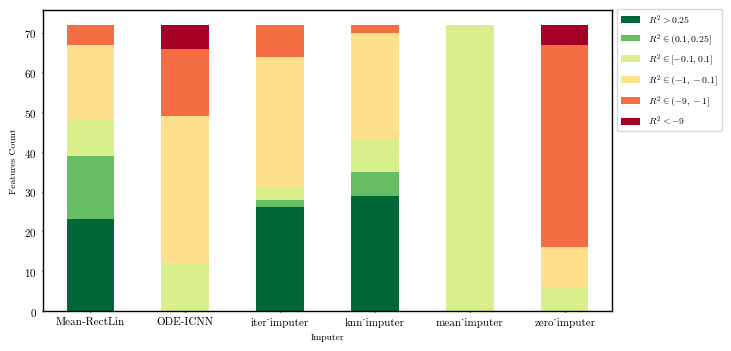

In [28]:
models_filtered_features_stats_df = all_models_features_stats_df[all_models_features_stats_df.Feature.isin(vars_n300)]
R_bins = models_filtered_features_stats_df.groupby(['Imputer', r'$R^2$ bin'])['Feature'].count().reset_index()
R_bins.columns = ['Imputer', r'$R^2$ bin', 'Count']
R_bins = R_bins.pivot_table(index="Imputer", values='Count', columns=r'$R^2$ bin')
R_bins = R_bins[R_classes]
ax = R_bins.iloc[:, :].plot(y=R_classes, kind="bar", rot=0, stacked=True, colormap='RdYlGn_r', ylabel='Features Count')
_ = ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
ax.get_figure().set_size_inches(fig_width_in * 1.2, fig_height_in * 2)
# ax.get_figure().savefig(f"{RESULTS_DIR}/R2_bins.pdf")

In [29]:
all_models_stats_df

,Imputer,MSE,$R^2$,MICRO-AVG($R^2$),MACRO-AVG($R^2$)*
0,ODE-ICNN,0.149789,-0.233968,-0.435029,-3.598631
0,Mean-RectLin,0.026943,0.778045,0.741880,0.008907
0,zero_imputer,0.192525,-0.586027,-0.844452,-4.511775
0,mean_imputer,0.105320,0.132369,-0.009002,-0.003999
0,knn_imputer,0.158953,-0.309460,-0.522822,0.105525
0,iter_imputer,0.067374,0.444972,0.354536,-0.239049
